# Imports and dataset loading

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.multioutput import MultiOutputRegressor
from sklearn import linear_model
from sklearn.neighbors import KNeighborsRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
import autokeras as ak
import tensorflow as tf
import pandas as pd

strategyArray  = []
gainArray      = []
lossArray      = []
channelTypeQnt = 3
ampNumber      = 2

originalDataSet = []
binaryDataSet   = []

gainScalerList = []
lossScalerList = []

originalDataSet.append(pd.read_csv('../datasets/1_channel_type/dataset-{}.txt'.format(ampNumber), sep = ',',header = None))
originalDataSet.append(pd.read_csv('../datasets/2_channel_type/dataset-{}.txt'.format(ampNumber), sep = ',',header = None))
originalDataSet.append(pd.read_csv('../datasets/4_channel_type/dataset-{}.txt'.format(ampNumber), sep = ',',header = None))

for i in range(channelTypeQnt):
    binaryDataSet.append([])
    for line in originalDataSet[i].values:
        myList = [1 if i != 0 else 0 for i in line[:40]]
        myList.extend(line[40:])
        binaryDataSet[i].append(myList)

    binaryDataSet[i] = pd.DataFrame(binaryDataSet[i])
    gainScaler       = MinMaxScaler(feature_range = (-1, 1))
    lossScaler       = MinMaxScaler(feature_range = (-1, 1))

    gainScalerAux = []
    lossScalerAux = []
    
    for j in range(0, ampNumber * 2, 2):
        gainScalerAux.extend(binaryDataSet[i].values[:, 40 + j])
        lossScalerAux.extend(binaryDataSet[i].values[:, 40 + j + 1])

    gainScaler.fit(np.array(gainScalerAux).reshape(-1, 1))
    lossScaler.fit(np.array(lossScalerAux).reshape(-1, 1))
    
    gainScalerList.append(gainScaler)
    lossScalerList.append(lossScaler)

def loadDataset(channelIndex): 
    dataSet = binaryDataSet[channelIndex].values[:, :40]
    
    for i in range(0, ampNumber * 2, 2):
        gain    = np.array(binaryDataSet[channelIndex].values[:, 40 + i])
        gain    = gainScaler.transform(gain.reshape(-1, 1))
        dataSet = np.hstack((dataSet, gain))
        
        loss    = np.array(binaryDataSet[channelIndex].values[:, 40 + i + 1])
        loss    = lossScaler.transform(loss.reshape(-1, 1))
        dataSet = np.hstack((dataSet, loss))
            
    features, result = np.array(dataSet[:, :40]), np.array(dataSet[:, 40:])
    return features, result

def invertGainNorm(value, channelIndex):
    auxArray = np.array([value, 0, 0, 0, 0, 0]).reshape(-1, 1)
    return gainScalerList[channelIndex].inverse_transform(auxArray)[0][0]

def invertLossNorm(value, channelIndex):
    auxArray = np.array([value, 0, 0, 0, 0, 0]).reshape(-1, 1)
    return lossScalerList[channelIndex].inverse_transform(auxArray)[0][0]
    
def getGainError(value1, value2, channelIndex):
    return abs(invertGainNorm(value1, channelIndex) - invertGainNorm(value2, channelIndex))

def getLossError(value1, value2, channelIndex):
    return abs(invertLossNorm(value1, channelIndex) - invertLossNorm(value2, channelIndex))

features, result = loadDataset(0)

Using TensorFlow backend.


# Cross validation function

In [2]:
def crossValidate(regressor, features, result, folds = 5):
    foldSize   = math.ceil(features.shape[0] / folds)
    gainErrors = []
    lossErrors = []
    
    for i in range(folds): 
        sliceBegin = i * foldSize
        sliceEnd   = (i + 1) * foldSize
        
        X_train = np.delete(features, np.s_[sliceBegin: sliceEnd], 0)
        y_train = np.delete(result, np.s_[sliceBegin: sliceEnd], 0)
        
        if isinstance(regressor, Sequential):
            regressor.fit(X_train, y_train, epochs = 500, verbose = 0)  
        else:
            regressor.fit(X_train, y_train)
            
        X_test = features[sliceBegin: sliceEnd]
        y_test = result[sliceBegin: sliceEnd]
        
        gainError = 0
        lossError = 0
        
        prediction = regressor.predict(X_test)
        
        for predicted, expected in zip(prediction, y_test):
            for i in range(0, ampNumber * 2, 2):
                gainError += getGainError(predicted[i], expected[i], 0) 
                lossError += getLossError(predicted[i + 1], expected[i + 1], 0)
                 
        gainErrors.append((gainError / ampNumber) / foldSize)
        lossErrors.append((lossError / ampNumber) / foldSize) # average loss error by amp
        
    return np.array(gainErrors), np.array(lossErrors)

In [3]:
def trainModel(strategy, channelIndex):   
    features, result       = loadDataset(channelIndex)
    gainErrors, lossErrors = crossValidate(strategy, features, result)

    print(gainErrors, "=> %0.2f (+/- %0.2f)" % (np.mean(gainErrors), gainErrors.std() * 2))
    print(lossErrors, "=> %0.2f (+/- %0.2f)" % (np.mean(lossErrors), lossErrors.std() * 2))
    
    gainArray[channelIndex].append(gainErrors)
    lossArray[channelIndex].append(lossErrors)
    
    return gainErrors, lossErrors

In [4]:
def setANN():
    model = Sequential()
    
    model.add(Dense(4, input_dim = 4, kernel_initializer = 'random_uniform', activation = 'sigmoid'))
    model.add(Dense(8, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(16, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(16, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(32, kernel_initializer = 'normal', activation = 'sigmoid'))  
    model.add(Dense(32, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(64, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(64, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(64, kernel_initializer = 'normal', activation = 'sigmoid')) 
    model.add(Dense(64, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(32, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(32, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(16, kernel_initializer = 'normal', activation = 'sigmoid'))  
    model.add(Dense(16, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(8, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(8, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(4, kernel_initializer = 'normal', activation = 'sigmoid'))
    model.add(Dense(2, kernel_initializer = 'random_uniform', activation = 'relu'))

    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# Plotting functions

In [5]:
def plotErrorBoxPlots():
    fig, axis = plt.subplots(2, 3, figsize = (10, 5))
    
    p1 = axis[0, 0].boxplot(gainArray[0])
    axis[0, 0].set_ylabel("Gain Absolute Error (dB)", fontsize = 8)
    axis[0, 0].set_ylim([1, 5])
    
    axis[0, 1].boxplot(gainArray[1])
    axis[0, 1].set_ylim([1, 5])
    
    axis[0, 2].boxplot(gainArray[2])
    axis[0, 2].set_ylim([1, 5])
    
    axis[1, 0].boxplot(lossArray[0])
    axis[1, 0].set_ylabel("Loss Absolute Error (dB)", fontsize = 8)
    axis[1, 0].set_xlabel("1 channel type", fontsize = 8)
    axis[1, 0].set_ylim([1, 5])
    
    axis[1, 1].boxplot(lossArray[1])
    axis[1, 1].set_xlabel("2 channel type", fontsize = 8)
    axis[1, 1].set_ylim([1, 5])
    #axis[1, 1].get_yaxis().set_visible(False)
    
    axis[1, 2].boxplot(lossArray[2])
    axis[1, 2].set_xlabel("4 channel type", fontsize = 8)
    axis[1, 2].set_ylim([1, 5])
    #axis[1, 2].get_yaxis().set_visible(False)
    
    fig.suptitle("Train error", fontsize = 16)
    fig.legend(p1["boxes"], strategyArray, handlelength = 0, bbox_to_anchor=(0.7, 0.81), loc = "right")
    
    #fix scale
    
    plt.show()

In [6]:
def plotGainDistribution(regressor):
    return
    features, result = loadDataset(channelIndex)

    predicted = regressor.predict(features)
    fig, axis = plt.subplots(figsize = (10, 5))
    vFunc     = np.vectorize(invertGainNorm)
    
    axis.scatter(vFunc(result[:, 0], 0), vFunc(predicted[:, 0], 0))
    axis.set_title("Gain Distribution")
    axis.set_xlabel("Expected")
    axis.set_ylabel("Predicted")

    plt.show()

In [7]:
def plotLossDistribution(regressor):
    return
    features, result = loadDataset(0)

    predicted = regressor.predict(features)
    fig, axis = plt.subplots(figsize = (10, 5))
    vFunc     = np.vectorize(invertLossNorm)
    
    axis.scatter(vFunc(result[:, 1], 0), vFunc(predicted[:, 1], 0), c = "m")
    axis.set_title("Loss Distribution")
    axis.set_xlabel("Expected")
    axis.set_ylabel("Predicted")

    plt.show()

# Putting all together

In [8]:
gainArray = [[],[],[]]
lossArray = [[],[],[]]

In [9]:
for i in range(channelTypeQnt):
    linearSVR = MultiOutputRegressor(SVR(kernel = "rbf", C = 1.0, gamma = 'scale', epsilon = 0.2))
    trainModel(linearSVR, i)
    
strategyArray.append("1 - SVR (Linear)")
plotGainDistribution(linearSVR)
plotLossDistribution(linearSVR)

[3.20019021 1.89724148 1.45309967 2.01705512 2.6340946 ] => 2.24 (+/- 1.22)
[2.91467548 2.51689437 1.91403739 1.95209854 1.53860039] => 2.17 (+/- 0.97)
[2.35079234 1.9256738  2.38311341 2.48595102 1.9762503 ] => 2.22 (+/- 0.46)
[2.08382311 1.77617013 1.50711638 1.25994223 1.55846612] => 1.64 (+/- 0.55)
[2.28842588 2.56252922 2.22017341 2.34720213 2.52266534] => 2.39 (+/- 0.27)
[2.07036162 1.82643083 1.37699075 1.77594401 1.41582728] => 1.69 (+/- 0.52)


In [10]:
for i in range(channelTypeQnt):
    lasso = MultiOutputRegressor(linear_model.Lasso(alpha = 0.2))
    trainModel(lasso, i)
    
strategyArray.append("2 - Lasso")
plotGainDistribution(lasso)
plotLossDistribution(lasso)

[3.14450997 2.36913728 1.9135181  2.30024742 2.62785976] => 2.47 (+/- 0.81)
[2.66763406 2.44843765 2.34690797 1.71901746 1.6243025 ] => 2.16 (+/- 0.83)
[2.7095974  2.3004824  2.65064618 2.33893157 2.94618906] => 2.59 (+/- 0.48)
[1.96420404 2.02764278 1.84205825 1.64402358 1.44287158] => 1.78 (+/- 0.43)
[2.49331129 2.56902472 2.38294461 2.68501328 2.69908663] => 2.57 (+/- 0.24)
[2.04813028 1.83777565 1.57800897 1.70385464 1.36934987] => 1.71 (+/- 0.46)


In [11]:
for i in range(channelTypeQnt):
    lars = MultiOutputRegressor(linear_model.Lars(n_nonzero_coefs=1))
    trainModel(lars, i)
    
strategyArray.append("3 - LARS")
plotGainDistribution(lars)
plotLossDistribution(lars)

[3.19487091 2.32599305 1.87412742 2.26208979 2.86554713] => 2.50 (+/- 0.94)
[2.78833325 2.55241816 2.26063875 1.69997034 1.82634817] => 2.23 (+/- 0.83)
[2.75198002 2.34437261 2.59250517 2.31530359 3.05033046] => 2.61 (+/- 0.55)
[2.05284082 1.87294095 1.67679598 1.45682578 1.49364678] => 1.71 (+/- 0.45)
[2.59073348 2.53280038 2.39276006 2.62563989 2.6095603 ] => 2.55 (+/- 0.17)
[2.02642273 1.82380554 1.55747264 1.72484507 1.36643103] => 1.70 (+/- 0.45)


In [12]:
for i in range(channelTypeQnt):
    huber = MultiOutputRegressor(linear_model.HuberRegressor(max_iter = 10000))
    trainModel(huber, i)
    
strategyArray.append("4 - Huber")
plotGainDistribution(huber)
plotLossDistribution(huber)

[3.34936057 2.59765127 1.49441525 1.98732114 3.70668252] => 2.63 (+/- 1.64)
[3.2561722  2.43358774 1.93971214 2.07765857 1.64484054] => 2.27 (+/- 1.11)
[2.16635343 4.42573509 2.51692889 2.46755091 2.06412976] => 2.73 (+/- 1.73)
[2.39138518 1.94117689 1.55555663 1.14928288 1.83837762] => 1.78 (+/- 0.83)
[3.34181631 2.41923418 3.98900994 2.72648888 2.67162446] => 3.03 (+/- 1.14)
[3.11294755 1.95237459 3.02133705 2.12869522 1.93019212] => 2.43 (+/- 1.05)


In [13]:
for i in range(channelTypeQnt):
    knn = MultiOutputRegressor(KNeighborsRegressor())
    trainModel(knn, i)
    
strategyArray.append("5 - KNN")
plotGainDistribution(knn)
plotLossDistribution(knn)

[4.79291339 2.59448819 1.55590551 1.98976378 3.48346457] => 2.88 (+/- 2.31)
[1.93464567 2.61968504 1.71968504 1.66771654 1.37716535] => 1.86 (+/- 0.84)
[2.25413793 3.35241379 2.34827586 2.54862069 1.78137931] => 2.46 (+/- 1.03)
[2.36724138 2.12724138 1.54034483 1.23       1.55103448] => 1.76 (+/- 0.84)
[2.33615561 2.55263158 2.33569794 2.54828375 2.76361556] => 2.51 (+/- 0.32)
[1.99427918 1.62471396 1.61487414 1.58627002 1.39130435] => 1.64 (+/- 0.39)


In [14]:
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import ExtraTreeRegressor

for i in range(channelTypeQnt):
    extra_tree = ExtraTreeRegressor(criterion = "mse", random_state=0)
    bret = MultiOutputRegressor(BaggingRegressor(base_estimator = extra_tree, n_estimators = 100, random_state = 0))
    trainModel(bret, i)
    
strategyArray.append("6 - Extra Tree")
plotGainDistribution(bret)
plotLossDistribution(bret)

[3.59789283 2.20300916 1.48904939 1.91988657 3.53008008] => 2.55 (+/- 1.72)
[3.28413027 2.52252018 1.86208214 2.02370059 1.66292943] => 2.27 (+/- 1.16)
[2.32422266 2.14795303 2.47516011 2.39940742 1.66829617] => 2.20 (+/- 0.58)
[2.25881282 1.70498098 1.38024379 1.18422105 1.53604857] => 1.61 (+/- 0.73)
[2.28030273 2.54959675 2.16747833 2.11840826 2.23046254] => 2.27 (+/- 0.30)
[1.99392795 1.75252873 1.32392993 1.63154139 1.46799795] => 1.63 (+/- 0.46)


In [15]:
from sklearn.ensemble import RandomForestRegressor

for i in range(channelTypeQnt):
    randomForest = RandomForestRegressor(max_depth = 8, random_state = 0, n_estimators = 100)
    trainModel(randomForest, i)

strategyArray.append("7 - Random Forest")
plotGainDistribution(randomForest)
plotLossDistribution(randomForest)

[3.598135   2.21180179 1.48918672 1.91722748 3.53032614] => 2.55 (+/- 1.72)
[3.28367362 2.51621121 1.86204802 2.02503108 1.66260787] => 2.27 (+/- 1.16)
[2.33711576 2.12484008 2.50593459 2.37930018 1.69563841] => 2.21 (+/- 0.57)
[2.04556192 1.7097588  1.40865844 1.16979828 1.53267632] => 1.57 (+/- 0.59)
[2.66654088 2.586815   2.10002545 2.16017892 2.3860968 ] => 2.38 (+/- 0.45)
[2.03865469 1.82585137 1.31792549 1.61625216 1.43648129] => 1.65 (+/- 0.52)


# Plotting error boxplots

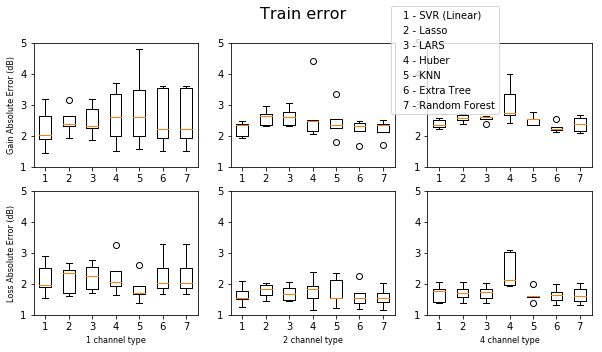

In [16]:
plotErrorBoxPlots()